In [ ]:
import torch
from PIL import Image
import numpy as np
from typing import Optional, Tuple, Union
from diffusers import DDPMPipeline, ImagePipelineOutput
from diffusers.utils import deprecate
# import DiffusionPipeline
import torch
from diffusers.configuration_utils import FrozenDict
torch.cuda.empty_cache()
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
from dataclasses import dataclass
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
import torchvision
from torchvision import transforms


In [ ]:

@dataclass
class TrainingConfig:
    image_size = 128  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 100
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "samples_immiscible"  # the model name locally and on the HF Hub

    push_to_hub = False  # whether to upload the saved model to the HF Hub
    hub_model_id = "<your-username>/<my-awesome-model>"  # the name of the repository to create on the HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0


config = TrainingConfig()
config.dataset_name = "data"

preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)
dataset = torchvision.datasets.ImageFolder(config.dataset_name, preprocess)
dataset

Dataset ImageFolder
    Number of datapoints: 2271
    Root location: data
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )

In [10]:
# get 2 first images
image_1 = dataset[0][0].unsqueeze(0)
image_2 = dataset[3][0].unsqueeze(0)
print(image_1.shape, image_2.shape)

torch.Size([1, 3, 128, 128]) torch.Size([1, 3, 128, 128])


In [ ]:
noise = torch.randn(image_1.shape)

In [157]:
NOISE_TIME_STEP = 250

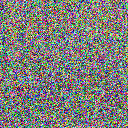

In [ ]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
timesteps = torch.LongTensor([NOISE_TIME_STEP])
noisy_image_1 = noise_scheduler.add_noise(image_1, noise, timesteps)
Image.fromarray(((noisy_image_1.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

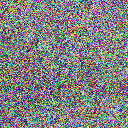

In [159]:
noisy_image_2 = noise_scheduler.add_noise(image_2, noise, timesteps)
Image.fromarray(((noisy_image_2.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

In [ ]:
np.linspace(0, 1, 7)

In [ ]:
class MixedDDPMPipeline(DDPMPipeline):
    def __init__(self, unet, scheduler):
        super().__init__(unet, scheduler)

    @torch.no_grad()
    def __call__(
        self,
        batch_size: int = 1,
        generator: Optional[torch.Generator] = None,
        num_inference_steps: int = 1000,
        start_timestep: int = 0,
        init_image = None, 
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        **kwargs,
    ) -> Union[ImagePipelineOutput, Tuple]:
        r"""
        Args:
            batch_size (`int`, *optional*, defaults to 1):
                The number of images to generate.
            generator (`torch.Generator`, *optional*):
                A [torch generator](https://pytorch.org/docs/stable/generated/torch.Generator.html) to make generation
                deterministic.
            num_inference_steps (`int`, *optional*, defaults to 1000):
                The number of denoising steps. More denoising steps usually lead to a higher quality image at the
                expense of slower inference.
            output_type (`str`, *optional*, defaults to `"pil"`):
                The output format of the generate image. Choose between
                [PIL](https://pillow.readthedocs.io/en/stable/): `PIL.Image.Image` or `np.array`.
            return_dict (`bool`, *optional*, defaults to `True`):
                Whether or not to return a [`~pipeline_utils.ImagePipelineOutput`] instead of a plain tuple.

        Returns:
            [`~pipeline_utils.ImagePipelineOutput`] or `tuple`: [`~pipelines.utils.ImagePipelineOutput`] if
            `return_dict` is True, otherwise a `tuple. When returning a tuple, the first element is a list with the
            generated images.
        """
        message = (
            "Please make sure to instantiate your scheduler with `prediction_type` instead. E.g. `scheduler ="
            " DDPMScheduler.from_pretrained(<model_id>, prediction_type='epsilon')`."
        )
        
        if generator is not None and generator.device.type != self.device.type and self.device.type != "mps":
            message = (
                f"The `generator` device is `{generator.device}` and does not match the pipeline "
                f"device `{self.device}`, so the `generator` will be ignored. "
                f'Please use `torch.Generator(device="{self.device}")` instead.'
            )
            deprecate(
                "generator.device == 'cpu'",
                "0.11.0",
                message,
            )
            generator = None

        # Sample gaussian noise to begin loop
        if isinstance(self.unet.sample_size, int):
            image_shape = (batch_size, self.unet.in_channels, self.unet.sample_size, self.unet.sample_size)
        else:
            image_shape = (batch_size, self.unet.in_channels, *self.unet.sample_size)

        lst_noises = []

        if init_image is not None:
            image_1 = init_image[0]
            assert isinstance(image_1, torch.Tensor), "start_images must be a tuple of torch.Tensor"
            image_1 = image_1.to(self.device)
            image_2 = init_image[1]
            assert isinstance(image_2, torch.Tensor), "start_images must be a tuple of torch.Tensor"
            image_2 = image_2.to(self.device)
            print("Using start images")
        else :
            if self.device.type == "mps":
                # randn does not work reproducibly on mps
                image_1 = torch.randn(image_shape, generator=generator)
                image_1 = image.to(self.device)
                image_2 = torch.randn(image_shape, generator=generator)
                image_2 = image.to(self.device)
            else:
                image_1 = torch.randn(image_shape, generator=generator, device=self.device)
                image_2 = torch.randn(image_shape, generator=generator, device=self.device)
        # set step values
        timesteps = self.scheduler.timesteps[self.scheduler.timesteps <= begin_inference_steps]
        for lambda_ in tqdm(np.linspace(0, 1, 7)):
            image = lambda_ * image_1 + (1 - lambda_) * image_2
            lst_noises.append(image)
        # concatenate to make a batch
        image = torch.cat(lst_noises, dim=0)
        print(image.shape)

        # Only run the loop from the specified starting timestep
        timesteps = self.scheduler.timesteps[self.scheduler.timesteps <= start_timestep]

        for t in self.progress_bar(timesteps):
            # 1. predict noise model_output
            model_output = self.unet(image, t).sample

            # 2. compute previous image: x_t -> x_t-1
            image = self.scheduler.step(model_output, t, image, generator=generator).prev_sample

        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.cpu().permute(0, 2, 3, 1).numpy()
        if output_type == "pil":
            image = self.numpy_to_pil(image)
        
        return image  # Reverse to get noisiest first

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

Using start images


/tmp/ipykernel_784304/3206261227.py:71: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DModel's config object instead, e.g. 'unet.config.in_channels'.
  image_shape = (batch_size, self.unet.in_channels, self.unet.sample_size, self.unet.sample_size)


  0%|          | 0/7 [00:00<?, ?it/s]

torch.Size([7, 3, 128, 128])


  0%|          | 0/1 [00:00<?, ?it/s]

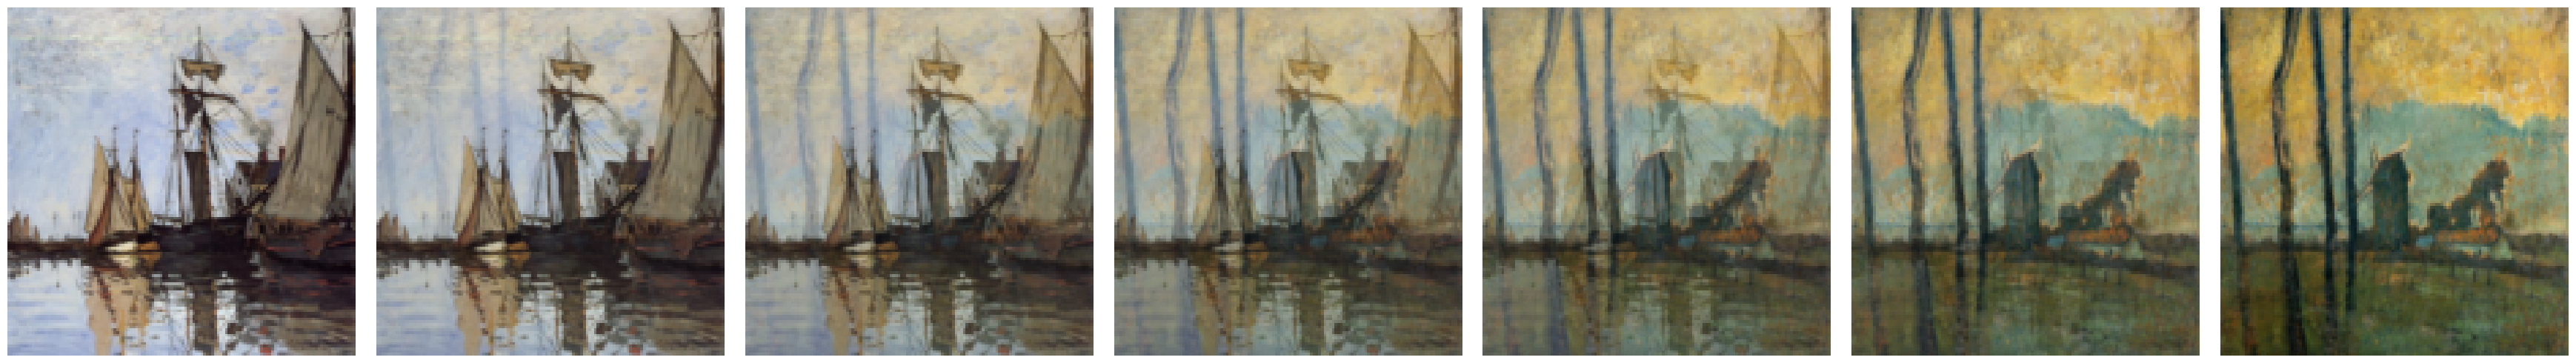

Using start images


  0%|          | 0/7 [00:00<?, ?it/s]

torch.Size([7, 3, 128, 128])


  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
# Load the trained pipeline
pipeline = DDPMPipeline.from_pretrained(config.output_dir)
# Ensure pipeline is set to evaluation mode
pipeline.unet.eval()
modified_pipeline = MixedDDPMPipeline(pipeline.unet, pipeline.scheduler)
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(image_1.shape)



for begin_inference_steps in [0, 124, 249, 374, 499, 624, 749, 874, 999]:
   timesteps = torch.LongTensor([begin_inference_steps])
   noisy_image_1 = noise_scheduler.add_noise(image_1, noise, timesteps)
   noisy_image_2 = noise_scheduler.add_noise(image_2, noise, timesteps)

   output = modified_pipeline(batch_size=1, 
                                 generator=torch.Generator(device='cpu').manual_seed(config.seed),
                                 num_inference_steps= 1000 ,
                                 start_timestep = begin_inference_steps,   
                                 init_image=[noisy_image_1, noisy_image_2],
                              )  # seed 42 works well for this example


   num_images = len(output)
   cols = num_images
   rows = 1

   # Create a grid of subplots
   fig, axes = plt.subplots(rows, cols, figsize=(5 * num_images, 5))

   # Ensure `axes` is iterable, even for a single row
   if num_images == 1:
      axes = [axes]

   for i, ax in enumerate(axes):
      ax.imshow(output[i])
      ax.axis("off")  # Hide axes

   # Adjust spacing between subplots
   plt.subplots_adjust(wspace=0.2, hspace=0.2)  # Adjust these values to control spacing
   plt.tight_layout()
   plt.savefig(f"others/mix/mixed_start_at_timestep_{begin_inference_steps}.png")
   plt.show()
